### 추천 시스템 제작(하루3끼)

In [26]:
# %autosave 0
import warnings
warnings.filterwarnings(action='ignore')

import os

import numpy as np
import pandas as pd
import seaborn as sb

from IPython.display import Image

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩
from tensorflow.keras.optimizers import Adam    # 가중치, bias 최적화

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

import matplotlib.pyplot as plt

from matplotlib import font_manager, rc

import platform 

if (platform.system() == 'Windows'):  # Windows, Linux, Darwin
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:    
    plt.rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/ai7/dnn/recommendation' # Colab

plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline

In [27]:
# header가 있을경우 skiprows=1 선언
data = np.loadtxt(path + '/train1.csv', delimiter=',', skiprows=1, dtype=np.float64)   # 특성이 작은 데이터의 예외 추가
print(type(data))
print(data.shape)

<class 'numpy.ndarray'>
(370, 26)


In [28]:
# 데이터와 class의 분리
# 0: 닭가슴살
# 1: 간편요리
# 2: 샐러드
# 3: 건강미용
# 4: 간식
X = data[:, 0:25]  # 0 ~ 24
print(X.shape)
Y = data[:, 25]    # 25 번째 데이터, class의 분리
print(Y.shape)

(370, 25)
(370,)


In [29]:
print(Y)

[0. 1. 2. 3. 4. 0. 1. 2. 3. 4. 0. 1. 2. 3. 4. 0. 1. 2. 3. 4. 0. 1. 2. 3.
 4. 0. 1. 2. 3. 4. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 2. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 3. 0. 0. 0. 0. 0. 1. 4. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 1. 1. 0. 1. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 3. 0. 0. 0. 0. 0.
 1. 4. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 2. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 3. 0. 0. 0. 0. 0. 1. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2.
 0. 0. 2. 0. 0. 2. 2. 2. 0. 0. 0. 0. 0. 2. 3. 0. 0. 0. 0. 0. 2. 4. 0. 1.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 2. 1. 1. 1. 1. 1. 0.
 3. 1. 1. 1. 1. 1. 0. 4. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 2. 1. 1. 1. 1. 1. 0. 3. 1. 1. 1. 1. 1. 0. 4. 0. 1. 0. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 2. 1. 1. 1. 1. 1. 0. 3. 1. 1. 1.
 1. 1. 0. 4. 0. 0. 2. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2. 0. 1. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 0. 3. 2. 2. 2. 2. 2. 0. 4. 0. 0. 2. 0. 0. 2. 2. 2. 2. 2.
 2. 2. 2. 0. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 3.

In [30]:
Y = Y.astype('int') # 정수로 형변환
print(Y)

[0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 0 0 0 0 0 1
 0 0 0 1 1 1 0 1 2 0 0 0 0 0 0 0 0 0 1 3 0 0 0 0 0 1 4 0 0 0 0 0 0 1 0 0 0
 1 1 1 0 1 2 0 0 0 0 0 0 0 0 0 1 3 0 0 0 0 0 1 4 0 0 0 0 0 0 1 0 0 0 1 1 1
 0 1 2 0 0 0 0 0 0 0 0 0 1 3 0 0 0 0 0 1 4 0 0 0 0 0 0 0 0 0 0 1 2 0 0 2 0
 0 2 2 2 0 0 0 0 0 2 3 0 0 0 0 0 2 4 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 2 1 1 1 1 1 0 3 1 1 1 1 1 0 4 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 1 1
 1 1 1 0 3 1 1 1 1 1 0 4 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 1 1 1 1 1
 0 3 1 1 1 1 1 0 4 0 0 2 0 0 2 2 2 2 2 2 2 2 0 1 2 2 2 2 2 2 2 2 2 2 0 3 2
 2 2 2 2 0 4 0 0 2 0 0 2 2 2 2 2 2 2 2 0 1 2 2 2 2 2 2 2 2 2 2 0 3 2 2 2 2
 2 0 4 0 0 2 0 0 2 2 2 2 2 2 2 2 0 1 2 2 2 2 2 2 2 2 2 2 0 3 2 2 2 2 2 0 4]


In [31]:
# 0: 닭가슴살
# 1: 간편요리
# 2: 샐러드
# 3: 건강미용
# 4: 간식
Y_encoded = to_categorical(Y) # one-hot-encoding

print(Y_encoded) 

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


In [32]:
print(X[0])
print(Y_encoded[0])

[0.96 0.01 0.01 0.01 0.01 0.96 0.01 0.01 0.01 0.01 0.96 0.01 0.01 0.01
 0.01 0.96 0.01 0.01 0.01 0.01 0.96 0.01 0.01 0.01 0.01]
[1. 0. 0. 0. 0.]


In [33]:
# train_test_split 분할을 통한 훈련, 검증, 테스트 데이터의 분리
seed = 0
# 90%: 분할대기, 10%: 테스트
x_train_all, x_test, y_train_all, y_test = train_test_split(X, Y_encoded,
                                           stratify=Y_encoded,
                                           test_size=0.1,
                                           random_state=seed)
# 나머지 데이터 90%를 분할, 80%: 훈련, 20%: 검증
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                           stratify=y_train_all,
                                           test_size=0.2,
                                           random_state=seed)

print(y_val)
print(y_val.shape)
# 닭가슴살: 0 , 간편요리: 1, 샐러드: 2 , 건강미용 : 3 , 간식 : 4
# (67, 5): 67건의 데이터가 입력되어 한건당 5가지에 속할 확률이 출력됨으로 67행 5열이됨.

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1.

In [34]:
print(y_test)
print(y_test.shape)
# (37, 5): 37건의 데이터가 입력되어 한건당 5가지에 속할 확률이 출력됨으로 37행 5열이됨.

[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
(37, 5)


In [42]:
model = Sequential()

# 네트워크 구성
# model.add(Dense(20, input_shape=(25, ), activation='relu'))
model.add(Dense(5, input_dim=25, activation='relu'))
# 0.98 0.01 0.01 0.98 0.01 0.01 0.98 0.01 0.01 -> 1 0 0 → 0 ~ 1 사이의 확률 5가지 출력, 총합은 1
model.add(Dense(5, activation='softmax'))
model.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy', 
                                metrics=['accuracy'])
model.summary()

mcp = ModelCheckpoint(filepath='./3kki2.h5', monitor='val_accuracy',
                      verbose=1, save_best_only=True)

es = EarlyStopping(monitor='loss', patience=1, restore_best_weights=True)

hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), shuffle=True,
                 epochs=100, batch_size=1, callbacks=[mcp, es])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 5)                 130       
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 30        
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
266/266 [==============================] - 1s 2ms/step - loss: 1.4042 - accuracy: 0.4197 - val_loss: 1.0303 - val_accuracy: 0.5821

Epoch 00001: val_accuracy improved from -inf to 0.58209, saving model to .\3kki2.h5
Epoch 2/100
266/266 [==============================] - 0s 1ms/step - loss: 0.9889 - accuracy: 0.5492 - val_loss: 0.7988 - val_accuracy: 0.7015

Epoch 00002: val_accuracy improved from 0.58209 to 0.70149, saving model to .\3kki2.h5
Epoch 3/100
266/266 [==============================] - 0s 1

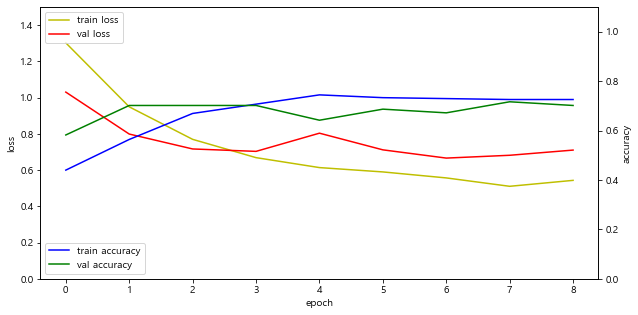

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.5]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1.1])

# 축 레이블 설정
loss_ax.set_xlabel('epoch' )  # 학습 횟수
loss_ax.set_ylabel('loss')    # 왼쪽 y 축 레이블, 오차
acc_ax.set_ylabel('accuracy') # 오른쪽 y 축 레이블,정확도

loss_ax.legend(loc='upper left') # 왼쪽 y 축 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 오른쪽 y 축 정확도 레이블 위치

plt.show()

In [44]:
test_loss, test_acc = model.evaluate(x_val, y_val, batch_size=1, verbose=0)
print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')

손실값: 0.6817086935043335 /정확도: 71.6417908668518 %


In [45]:
# model.save(path + '/Book.h5')

In [46]:
print('데이터:', x_test.shape) # 변수가 9개로 구성된 4건의 관측치(행)
print('데이터:', x_test[0])    # 첫번째 데이터행

p = model.predict(x_test)      # 테스트 데이터 4건 ★
print('예측 결과 p.shape:', p.shape)     # (4, 3): 3: 폼종의 갯수

데이터: (37, 25)
데이터: [0.01 0.96 0.01 0.01 0.01 0.96 0.01 0.01 0.01 0.01 0.01 0.96 0.01 0.01
 0.01 0.01 0.01 0.01 0.96 0.01 0.01 0.96 0.01 0.01 0.01]
예측 결과 p.shape: (37, 5)


In [47]:
print('예측값:', p[0])        # 첫번째 예측값 출력, 확률 0 ~ 1사이의 실수값
print('예측값의 합: {0:0.3f}'.format(np.sum(p[0])))
print('예측값: {0:.5f}% {1:.5f}% {2:.5f}%'.format(p[0,0]*100,p[0,1]*100,p[0,2]*100))
print('One-hot-encoding: ', y_test[0])
print(np.argmax(p[0]))      # 가장 큰값의 index

예측값: [1.1268056e-02 9.7152519e-01 1.6706467e-04 1.2928473e-02 4.1111275e-03]
예측값의 합: 1.000
예측값: 1.12681% 97.15252% 0.01671%
One-hot-encoding:  [0. 1. 0. 0. 0.]
1


In [48]:
print(p)

[[1.12680560e-02 9.71525192e-01 1.67064674e-04 1.29284728e-02
  4.11112746e-03]
 [7.73861587e-01 3.59347798e-02 1.25980496e-01 3.27525521e-03
  6.09477907e-02]
 [8.85907471e-01 3.41127031e-02 3.31253372e-02 4.49406058e-02
  1.91397977e-03]
 [6.84439391e-03 9.86449897e-01 1.07199186e-04 2.90999794e-03
  3.68842506e-03]
 [1.38622401e-02 4.24993550e-03 9.79620397e-01 9.77765194e-06
  2.25759833e-03]
 [9.00800005e-02 1.57797188e-02 8.81129652e-02 8.05174649e-01
  8.52716330e-04]
 [3.57310504e-01 4.63886093e-03 6.37452424e-01 1.66838036e-05
  5.81570261e-04]
 [1.96903432e-03 2.68713175e-03 9.95058060e-01 6.13911425e-07
  2.85206217e-04]
 [9.94559824e-01 3.08751734e-03 1.49100041e-03 7.31897453e-05
  7.88381207e-04]
 [9.37189311e-02 4.23259407e-01 1.48505438e-03 4.75323975e-01
  6.21270342e-03]
 [1.30427659e-01 5.82808197e-01 6.43370487e-03 7.63018876e-02
  2.04028532e-01]
 [1.38119897e-02 9.67943966e-01 4.34507034e-04 5.74179785e-03
  1.20677585e-02]
 [1.95801124e-01 3.16523798e-02 7.273524